In [1]:
import tensorflow as tf
import canton as ct
from canton import *
import numpy as np
import matplotlib.pyplot as plt

this is a toy example mentioned in <http://www.inference.vc/variational-inference-with-implicit-models-part-ii-amortised-inference-2/>

Here I'm trying to replicate Ferenc's results.

In [2]:
# define: the distribution of wetness is an exponential distribution conditioned on
# two i.i.d. variables: sprinkler and rain, as follows:

def sample_wetness(sprinkler, rain):
    beta = 3 + np.maximum(0,sprinkler)**3 + np.maximum(0,rain)**3
    return np.random.exponential(scale=beta)
# the wetness will be high when either sprinkler or rain is high.
    
# sprinkler and rain are iid gaussian. let's draw 10k samples from them:
latent = np.random.normal(loc=0,scale=2,size=(10000,2))
sprinkler = latent[:,0:1]
rain = latent[:,1:2]

# get wetness data
wetness = sample_wetness(sprinkler, rain)

print('[sprinkler,rain]')
print(latent[0:5])
print('wetness')
print(wetness[0:5])

print(sprinkler.shape, rain.shape, wetness.shape)

[sprinkler,rain]
[[ 2.92275015  1.98327429]
 [ 3.42923084  1.73805362]
 [ 2.78288338 -0.07092004]
 [-4.94130653  0.7177319 ]
 [-3.36309066 -2.61336222]]
wetness
[[ 19.73373678]
 [ 39.820237  ]
 [ 40.40627567]
 [  1.94119451]
 [  4.8459917 ]]
(10000, 1) (10000, 1) (10000, 1)


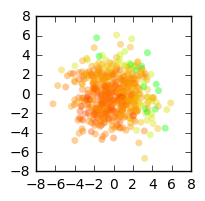

In [3]:
# now plot it

def plot(sprinkler,rain,wetness): # all of shape [batch, 1]
    colors = np.zeros((len(wetness),4),dtype='float32')
    colors[:,3] = 0.4 # transparency
    colors[:,0] = 1.0 # assign red
    colors[:,1] = wetness[:,0] # assign green, the wetter the greener
    colors[:,1] /= 100 # scale down
    colors[:,1] = np.minimum(1., colors[:,1]) # clamping
    colors[:,0] -= colors[:,1] # tune down red where green is available
    colors[:,0:2] **= 0.2 # gamma scaling
    plt.figure(figsize=(2,2))
    plt.scatter(sprinkler,rain,s=25,c=colors,edgecolors='none')
    plt.show()

# green means wet while red means not
plot(sprinkler[0:500],rain[0:500],wetness[0:500])

In [4]:
# what would the distribution of sprinkler and rain be, when I observe wetness = 50 ?

# i'm not a fan of analytical methods, so let's just sample those between 45 and 55:
ind = np.where((wetness[:,0]>45) == (wetness[:,0]<55))
print(ind)

(array([  15,   54,   73,   99,  103,  133,  158,  183,  252,  296,  384,
        461,  493,  653,  709,  773,  780,  810,  831,  836,  869,  935,
        961, 1003, 1006, 1102, 1255, 1287, 1374, 1389, 1403, 1448, 1475,
       1586, 1670, 1850, 1868, 1980, 2140, 2184, 2198, 2205, 2369, 2430,
       2633, 2651, 2660, 2664, 2839, 3112, 3185, 3266, 3312, 3488, 3580,
       3654, 3692, 3747, 3782, 3815, 3896, 3940, 3946, 4023, 4149, 4478,
       4525, 4537, 4663, 4684, 4695, 4720, 4735, 5148, 5160, 5165, 5277,
       5349, 5589, 5663, 5673, 5775, 5888, 5903, 5936, 5966, 6000, 6051,
       6077, 6140, 6143, 6192, 6242, 6310, 6495, 6537, 6627, 6668, 6750,
       6888, 6893, 6983, 7019, 7086, 7301, 7381, 7393, 7419, 7439, 7486,
       7497, 7541, 7615, 7705, 7790, 7801, 7843, 8004, 8267, 8290, 8368,
       8390, 8447, 8449, 8703, 8776, 8838, 9064, 9121, 9128, 9133, 9142,
       9143, 9177, 9235, 9490, 9522, 9621, 9638, 9646, 9651, 9749, 9753,
       9763, 9817, 9839, 9891, 9919], dtype=int64)

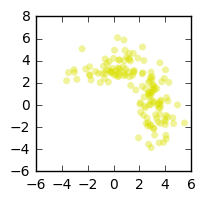

In [5]:
# plot em
plot(np.take(sprinkler,ind), np.take(rain,ind), np.take(wetness,ind))

The distribution in Ferenc's blogpost replicated!

Now I'll try to fit a Neural Network model that **variationally infers** sprinkler and rain, given wetness. Using GAN of course.

In [6]:
def generator():
    cw = Can()
    cw.add(Dense(1,10)) # [1 wetness]
    cw.add(Act('elu'))
    cw.add(Dense(10,20))
    cw.add(Act('elu'))
    cw.chain()
    
    cz = Can()
    cz.add(Dense(3,20)) # noise
    cz.add(Act('elu'))
    cz.chain()
    
    c = Can()
    c.incan([cw,cz])
    d1 = c.add(Dense(20,10))
    d2 = c.add(Dense(10,20))
    d3 = c.add(Dense(20,2))
    def call(i):
        w,gau = i[0], i[1]
        w = cw(w)
        gau = cz(gau)
        s = w+gau
        s = d1(s)
        s = Act('elu')(s)
        s = d2(s)
        s = Act('elu')(s)
        s = d3(s)
        return s
    c.set_function(call)
    return c

def discriminator():
    def batch_disc(i): # batch discrimination
        #assume i shape [N C]
        s = tf.shape(i)
        NC1 = tf.expand_dims(i,2)
        ACN = tf.expand_dims(tf.transpose(i,[1,0]),0)
        diffs = NC1 - ACN # [N C N]
        abs_diffs = tf.abs(diffs)
        # shape [N C N]
        feat = tf.reduce_mean(tf.exp(-abs_diffs), [1,2]) #[N]
        feat = tf.expand_dims(feat,1)
        # shape [N 1]
        out = tf.concat([i, feat],axis=-1) # [N C+1]
        return out
    
    cw = Can()
    cw.add(Dense(1,10)) # [1 wetness]
    cw.add(Act('elu'))
    cw.add(Dense(10,20))
    cw.add(Act('elu'))
    cw.chain()
    
    cz = Can()
    cz.add(Dense(2,10))
    cz.add(Act('elu'))
    cz.add(Dense(10,20))
    cz.add(Act('elu'))
    cz.chain()
    
    c = Can()
    c.incan([cw,cz])
    d1 = c.add(Dense(20,10)) # [1 wetness 
    d2 = c.add(Dense(10,20)) #  64 + 2 inferred -> 64 ]
    d3 = c.add(Dense(20,1)) # 1
    def call(i):
        w,lat = i[0],i[1] # wetness and latent
        w = cw(w)
        lat = cz(lat)
        s = w+lat
        s = d1(s)
        s = Act('elu')(s)
        s = d2(s)
        s = Act('elu')(s)
        s = d3(s)
        s = Act('sigmoid')(s)
        return s
    c.set_function(call)
    return c

g,d = generator(),discriminator()

def feed_gen():
    wetness_input = ct.ph([1]) # wetness is 1d input
    w = wetness_input
    s = tf.shape(w)
    gaussian = tf.random_normal(mean=0, stddev=1, shape=[s[0],3]) # noise source
    
    latent = ct.ph([2]) # sprinkler and rain, real
    generated = g([w,gaussian]) # sprinkler and rain, generated
    
    noise = tf.Variable(.1)
    def noisy(i): # add instance noise to help convergence
        return i + tf.random_normal(mean=0,stddev=noise, shape=tf.shape(i))
    
    rscore = d([w,noisy(latent)]) # discriminator give a score
    gscore = d([w,noisy(generated)])
    
    # usual GAN loss
    
    def log_eps(i):
        return tf.reduce_mean(tf.log(i+1e-8))

    # single side label smoothing: replace 1.0 with 0.9
    dloss = - (log_eps(1-gscore) + .1 * log_eps(1-rscore)+ .9*log_eps(rscore))
    gloss = - log_eps(gscore)
    
    #dloss = tf.reduce_mean((gscore-0)**2 + (rscore-1)**2)
    #gloss = tf.reduce_mean((gscore-1)**2)
    
    #optimizer and updates
    opt = tf.train.AdamOptimizer(1e-3)
    update_wg = opt.minimize(gloss,var_list=g.get_weights())
    update_wd = opt.minimize(dloss,var_list=d.get_weights())
    train_step = [update_wd, update_wg]
    losses = [dloss,gloss]
    
    # feed function
    def gan_feed(batch_wetness,batch_latent,noise_level):
        # actual GAN training function
        sess = ct.get_session()
        nonlocal train_step,losses,w,latent

        res = sess.run([train_step,losses],feed_dict={
            wetness_input:batch_wetness,
            latent:batch_latent,
            noise:noise_level,
        })
        loss_values = res[1]
        return loss_values #[dloss,gloss]
    
    # d_feed
    def d_feed(batch_wetness,batch_latent,noise_level):
        # train D only
        sess = ct.get_session()
        res = sess.run([[update_wd],losses],feed_dict={
                wetness_input:batch_wetness,
                latent:batch_latent,
                noise:noise_level,
            })
        return res[1]
    
    return gan_feed,d_feed

feed,d_feed = feed_gen()    
ct.get_session().run(ct.gvi()) # global variables initializer

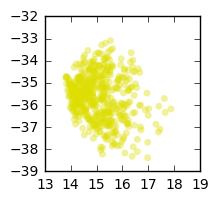

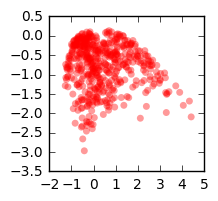

In [7]:
# model is built, now try inference with our generator, setting wetness 50 and 0:
def test_inference():
    gau = np.random.normal(loc=0,scale=1,size=(500,3)) # draw 3 gaussians
    w50 = np.ones((500,1)) * 50. # set wetness 50
    w0 = w50 * 0.
    inferred = g.infer([w50,gau])
    plot(inferred[:,0:1],inferred[:,1:2],w50)
    inferred = g.infer([w0,gau])
    plot(inferred[:,0:1],inferred[:,1:2],w0)
    
test_inference()

In [8]:
noise_level = 1.
# now train our model for a while, see what happens
def r(epochs=10,d_only=False): # specify whether only train D
    for i in range(epochs):
        losses = None
        bs = 25 # batch_size
        global noise_level
        noise_level *= .99
        for j in range(10000//bs): # minibatch of 25 feeding
            f = d_feed if d_only else feed
            losses = f(wetness[j*bs:(j+1)*bs],
                          latent[j*bs:(j+1)*bs],
                         noise_level=noise_level)
        print('epoch',i,'dloss:',losses[0],'gloss:',losses[1],'noise_level:',noise_level)

epoch 0 dloss: 1.19606 gloss: 1.13489 noise_level: 0.44304798162617254
epoch 1 dloss: 1.29105 gloss: 1.06634 noise_level: 0.4386175018099108
epoch 2 dloss: 1.307 gloss: 1.08624 noise_level: 0.4342313267918117
epoch 3 dloss: 1.22769 gloss: 1.18732 noise_level: 0.4298890135238936
epoch 4 dloss: 1.24555 gloss: 1.05004 noise_level: 0.42559012338865465
epoch 5 dloss: 1.09799 gloss: 1.30561 noise_level: 0.4213342221547681
epoch 6 dloss: 1.0801 gloss: 1.24283 noise_level: 0.41712087993322045
epoch 7 dloss: 1.08209 gloss: 1.56367 noise_level: 0.41294967113388825
epoch 8 dloss: 1.15069 gloss: 1.4951 noise_level: 0.40882017442254937
epoch 9 dloss: 1.12193 gloss: 1.29285 noise_level: 0.4047319726783239
epoch 10 dloss: 1.12687 gloss: 1.44808 noise_level: 0.40068465295154065
epoch 11 dloss: 0.939282 gloss: 1.55034 noise_level: 0.39667780642202527
epoch 12 dloss: 1.09188 gloss: 1.72022 noise_level: 0.392711028357805
epoch 13 dloss: 1.12932 gloss: 1.76568 noise_level: 0.38878391807422696
epoch 14 dlo

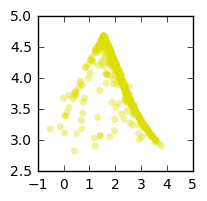

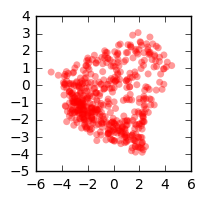

In [11]:
r(30,d_only=True) # could take a while.
r(10)

# ! you may have to run this block several times.
test_inference()

now you get the idea!